# Heterogeneous Agents

In [1]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import random

In [132]:
beta = 0.96
delta = 0.06
alpha = 0.36
u = 0.1
k_low = 0.001
k_high = 40
params = beta, delta, alpha, u

In [133]:
def get_kstar(kstar, *params):
    beta, delta, alpha, u = params
    f = (1 - beta*(1 - delta)*(alpha*np.sign(kstar)*np.abs(kstar)**(alpha - 1))*(1 - u)**(1 - alpha) + (1 - alpha)*np.sign(kstar)*np.abs(kstar)**(alpha)*(1 - u)**(-alpha))/(beta*(1 - delta)**(2) - beta*(1 - delta) - (1 - delta) + 1) - kstar
    return f

In [141]:
optimize.fsolve(get_kstar, 0.1, params)

array([0.10389588])

In [135]:
def get_kbar(params):
    beta, delta, alpha, u = params
    f = (alpha*beta/(1 - beta*(1- delta)))**(1/(1 - alpha))
    return f

In [136]:
def hetagents(kbar, k_low, k_high, params, N = 200, thresh = 1e-16, maxiters = 1000):
    beta, delta, alpha, u = params
    random.seed(111)
    kgrid = np.linspace(k_low, k_high, N)
    diff = 15
    V_old = np.zeros((2,N))
    V_new = np.zeros_like(V_old)
    c = np.zeros_like(V_old)
    u = np.zeros_like(V_old)
    policyfun = np.zeros_like(V_old)
    u = 0.1
    transition = np.array([[0.9, 0.1], [0.9, 0.1]])
    itr = 0
    
    while diff > thresh and itr <= maxiters:
        for i in range(len(kgrid)):
            k = kgrid[i]
            #Compute r(kbar) and w(kbar)
            r = alpha*kbar**(alpha - 1)*(1 - u)**(1 - alpha)
            w = (1 - alpha)*kbar**(alpha)*(1 - u)**(-alpha)
            c[0, :] = r*k + w*1 + (1 - delta)*k - kgrid
            c[1, :] = r*k + w*0 + (1 - delta)*k - kgrid   
            obj = np.zeros_like(V_old)
            obj[c <= 0] = -999999
            obj[c > 0]= np.log(c[c > 0])
            V_almost = obj + beta*(np.dot(transition, V_old))
            V_new[:, i] = np.amax(V_almost, axis = 1) 
            max_indicies = np.argmax(V_almost, axis = 1)
            policyfun[:, i] = kgrid[max_indicies]
        diff = np.linalg.norm(V_new - V_old)**(2)
        V_old = V_new.copy()
        itr += 1
        
        if diff <= thresh or itr == maxiters:
            print("Iteration:", str(itr), str(diff))
        
    return policyfun, V_new, kgrid

In [137]:
kbar = get_kbar(params)
policyfun, V_new, kgrid = hetagents(kbar, k_low, k_high, params, N = 200, thresh = 1e-16, maxiters = 1000)

Iteration: 485 9.839947355591388e-17


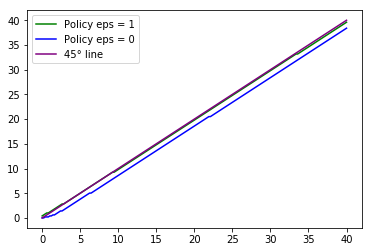

In [139]:
fig = plt.figure()
plt.plot(kgrid, policyfun[0, :], color = "g", label = "Policy eps = 1")
plt.plot(kgrid, policyfun[1, :], color = "b", label = "Policy eps = 0")
plt.plot(kgrid, kgrid, color = "purple", label = "45° line")
plt.legend()
plt.show();

In [138]:
def finalfun(params, kbar, thresh = 1e-16, maxiters = 1000):
    t = 10000
    capital_series = np.zeros(t)
    itr = 0
    diff = 15
    random.seed(111)
    
    while (diff > thresh and itr <= maxiters):
        policyfun, V_new, kgrid =  hetagents(kbar,k_low, k_high, params, N = 200, thresh = 1e-16, maxiters = 1000)
        k = random.choice(kgrid)
        capital_series[0] = k
        
        for i in range(1, t):
            epsilon = np.random.binomial(1, 0.9, 1)
            if epsilon == 1:
                k = policyfun[0, np.where(kgrid == k)[0]]
            else:
                k = policyfun[1, np.where(kgrid == k)[0]]
            capital_series[i] = k
        kbar_new = np.mean(capital_series)
        diff = kbar_new - kbar
        kbar = kbar_new.copy()
        itr += 1
        
        if diff <= thresh or itr==maxiters:
            print("Iteration:", str(itr), str(diff))
        
    return kbar_new

In [116]:
kbar = get_kbar(params)
finalfun(params, kbar, thresh = 1e-16, maxiters = 1000)

Iteration: 486 9.31531264044396e-17
Iteration: 1 -4.964808857423627


2.2463675351758794